# LINMA1702 modèles et méthodes d'optimisation
# Projet 2020-2021 : Logistique de la vaccination en Belgique
### Groupe 6 : Théau Lepouttre, Eliott Van Dieren et Nicolas Mil-Homens Cavaco


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mip import *

### Hypothèses

On considère un certaine population répartie en $m$ classes d'âge dans $n$ provinces en Belgique.
Parmi les personnes constituant cette population, on distingue $2$ parties disjointes:

* les personnes susceptibles 
* les autres, c'est-à-dire les malades, les vaccinés, les guéris et les morts.
    
On suppose cette population comme constante dans le temps.
Notre objectif est de minimiser le nombre de morts dû à l'épidémie.

### Question 1.1

Dans ce premier modèle, on considère le cas d'un seul centre ($n=1$).
En outre, le stockage des vaccins n'est pas autorisé.
On suppose également que la durée de la campagne de vaccination s'étant sur une durée de $T$ jours.

Soit les variables suivantes

* $x^t \equiv$ le nombre de doses qui arrivent au centre de vaccination au temps $t$; 
* $y_i^t \equiv$ le nombre de doses administrées à la classe d'âge $i$ au temps $t$;
* $(n_s)_i^t \equiv$ le nombre de personnes susceptibles parmi les personnes de la classe $i$ au temps $t$.
$(n_s)_i^t$ est considéré comme une variable car il dépend directement du nombre de personnes que l'on vaccine.

contraintes par les paramètres suivants,

* $b_c^t \equiv$ le nombre de vaccins livrés dans l'entrepôt central;
* $b_l^t \equiv$ le nombre maximal de vaccins livrés au temps $t$;
* $b_v^t \equiv$ le nombre maximal de vaccins administrés au temps $t$;
* $c_{tr} \equiv$ le coût de transport;
* $c_v \equiv$ le coût de vaccination;
* $c_{tot} \equiv$ le budget total disponible;

Soit 

* $\lambda_i^t \equiv$ la fraction parmi les personnes susceptibles tombant malade au jour $t$ pour la classe $i$.
* $\varepsilon_i^t \equiv$ la fraction parmi les personnes de la classe $i$ tombées malades au jour $t$ qui décèderont.
* $\mu_i \equiv$ la fraction de population disposée et autorisée à se faire vacciner.

On identifie les contraintes suivantes, classées en $2$ catégories:
- (1) les contraintes de capacités et de budget: 
    * Le budget total de la campagne de vaccination est limité.
    * Le nombre de vaccins livrés est limité chaque jour par le nombre de vaccins disponibles dans l'entrepôt central.
    * Le nombre de vaccins livrés est limité chaque jour par la limite du centre de vaccination.
    * Le nombre de vaccins administrés est limité chaque jour.
    * Seules les personnes disposées et autorisées peuvent se faire vacciner (18+ et consentant). 
   $$\\ $$
- (2) les contraintes physiques:
    * Le total de vaccins administrés au temps $t$ ne peut pas dépasser le nombre total de vaccins livrés la veille, et ce sur toute la durée de la campagne.
    * Le nombre de personnes vaccinées pour une classe $i$ au temps $t$ vaut le nombre de personnes susceptibles la veille auquel on soustrait le nombre de vaccinations et le nombre de personnes malades la veille.

    

Finalement, on prend la convention que $x^0 = 0 = x^T$, en d'autres termes aucun vaccin n'a été livré la veille du début de la campagne ou ne doit être livré le dernier jour. On note également par $(n_s)^0_i$ la population initiale.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, n_s}& \sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ (n_s)_i^t \\
\sum_{t=1}^T \left(c_{tr}\ x^t + c_v \sum_{i=1}^{m} y_i^t\right) &\leq& c_{tot} \\
x^{t} &\leq & b_c^t \qquad\\  
x^t &\leq& b_l^t \qquad \\
\sum_{i=1}^{m} y_i^t &\leq&\ b_v^t \\
\sum_{k=1}^t y_i^k &\leq& \mu_i\ (n_s)_i^0\\ %(n_s)_i^t - (n_{nv})_i^t \\
x^{t-1} - \sum_{i=1}^{m} y_i^t &\geq& 0\\
(n_s)_i^t - (1-\lambda_i^{t-1})\ (n_s)_i^{t-1} + y_i^{t-1} &=&  0\\
x,\ y,\ n_s &\geq& 0
\end{eqnarray*}$$

In [109]:
# Données du problème
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_tot = 100e6         # budget total autorisé
b_l   = float("inf")  # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

# Population initiale
n_s_init = [3778123, 2846993, 2790883, 1390502, 111533]  

# Fraction de malades
lambda_t = lambda t: np.array([0.000298 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000301 * (1/5 + np.sin(t/50)**2),
                               0.000204 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000209 * (1/5 + np.sin(t/50-2/5)**2),
                               0.000329 * (1/5 + np.sin(t/50-2/5)**2)])

# Fraction de morts
epsilon_t = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])

mu  = np.array([0.3, 0.6, 0.7, 0.9, 0.9])     # proportion de la population disposée à se faire vacciner.

# Quantité livrée au hangar central -> w1 (Vaccins au prix 1 achetés) + w2 (Vaccins au prix 2 achetés)
b_c = np.zeros(T);
days = np.arange(1, T+1)
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]

for t in days-1:
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]

b_c[-1] = b_c_eff[-1] # /!\: à modifier

_lambda  = lambda_t(days)
_epsilon = epsilon_t(days)

In [110]:
def init_variables(model, m, t):
    """
    Initialise les variables x,y,n_s au format: x[t], y[t][i], n_s[t][i].
    @args: 
        model: mip Model: modèle d'optimisation linéaire
        m: int: nombre de classes d'âge
        t: int: durée de la campagne
    @returns:
        x: List[Var]: variables de livraison
        y: List[List[Var]]: variables d'administration des vaccins
        n_s: List[List[Var]]: nombre de susceptibles
    """
    x = [model.add_var() for _ in range(t)]
    y = model.add_var_tensor((t, m), 'y')
    n_s = model.add_var_tensor((t, m), 'n_s')
    
    return x, y, n_s

In [111]:
# Résolution du problème
model_I1 = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x, y, n_s = init_variables(model_I1, m, len(days))

# Objectif
model_I1.objective = minimize(xsum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i] for i in range(m) for t in days[1:-1]))

# Contraintes
model_I1 += xsum(c_tr * x) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot
for t in days-1:
    model_I1 += x[t] <= b_c[t]
    if t > 1: 
        model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0
    
    yn_s = n_s[t-1] if t > 1 else n_s_init
    for i in range(m):
        model_I1 += n_s[t][i] - (1 - _lambda[i,t-1]) * yn_s[i] + y[t-1][i] == 0
        
    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v
    for i in range(m):
        model_I1 += xsum(y[k][i] for k in range(t)) - mu[i] * n_s_init[i]  <= 0

model_I1.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [112]:
print(f"f(x,y) = {model_I1.objective_value}")

# Sauvegarde des données du solveur
model_I1.write("Q1_1.lp")
model_I1.write("Q1_1.sol")

f(x,y) = 2450.544793217417


In [113]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [x[t].x for t in days-1]
vaccination = [[y[t][i].x for t in days-1] for i in range(m)]
susceptible = [[n_s[t][i].x for t in days[1:-1]] for i in range(m)]
pop_s       = [sum(n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_malade  = [sum( _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]
pop_morte   = [sum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i].x for i in range(m)) for t in days[1:-1]]


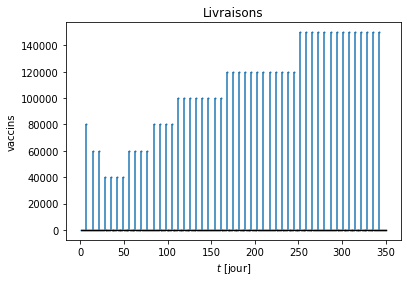

In [114]:
# Plot des livraisons
plt.figure()
plt.title("Livraisons")
markerline, stemlines, baseline = plt.stem(days, livraisons)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()   

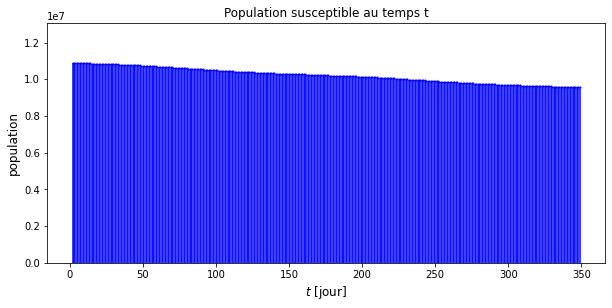

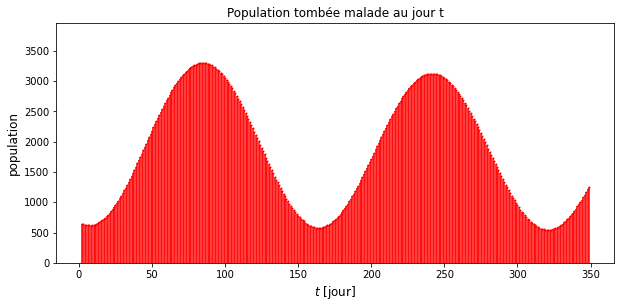

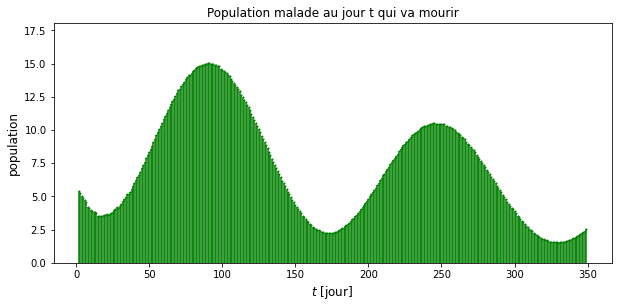

In [115]:
# Plot des populations
pop = [pop_s, pop_malade, pop_morte]
color = ['b','r','g']
titres_pop = ["Population susceptible au temps t", "Population tombée malade au jour t", "Population malade au jour t qui va mourir"]

for i in range(3):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 1, i + 1)
    plt.title(titres_pop[i])
    #plt.plot(days[1:-1], pop[i], "-"+color[i])
    markerline, stemlines, baseline = plt.stem(days[1:-1], pop[i], "-"+color[i])
    plt.xlabel("$t$ [jour]", fontsize=12)
    plt.ylabel("population", fontsize=12)
    plt.ylim((0, max(pop[i])*1.2))
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_color(color[i])
    markerline.set_markersize(1)
    plt.show()

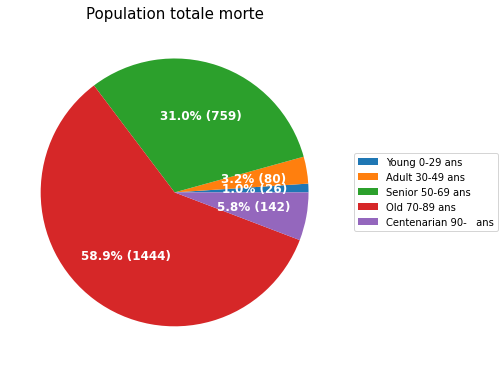

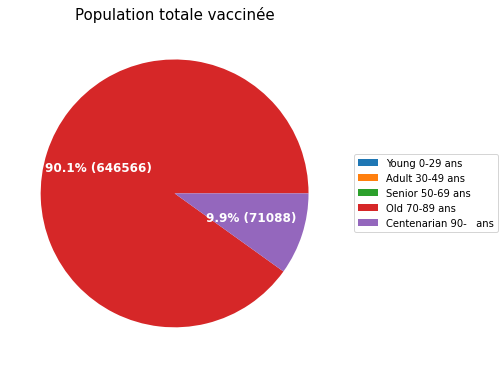

In [116]:
data_pmorte    = [sum(_epsilon[i,t] * _lambda[i,t] * n_s[t][i].x for t in days[1:-1]) for i in range(m)]
data_pvaccinee = [sum(y[t][i].x for t in days[1:-1]) for i in range(m)]
data = [data_pmorte, data_pvaccinee]
titles = ["Population totale morte", "Population totale vaccinée"]

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    
    return "{:.1f}% ({:d})".format(pct, absolute) if absolute > 1e-5 else ""


for d,title in zip(data, titles):
    fig, ax = plt.subplots(figsize=(6, 9), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(d, autopct=lambda pct: func(pct, d),textprops=dict(color="w"))
    
    ax.legend(wedges, population,
          loc="center",
          bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title(title, fontsize=15)
    plt.show()

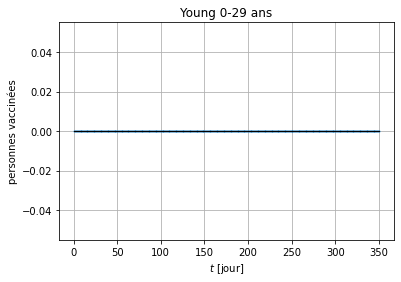

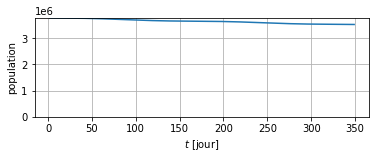

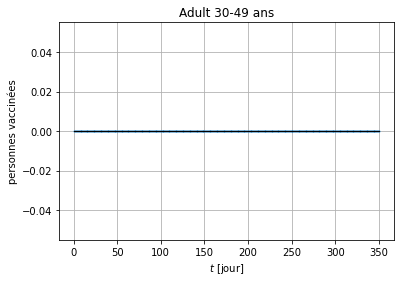

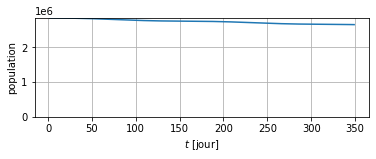

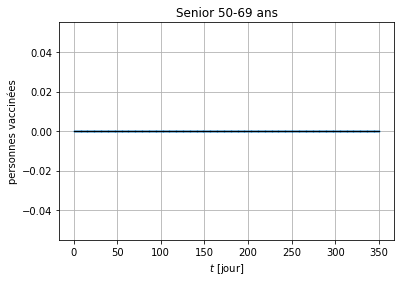

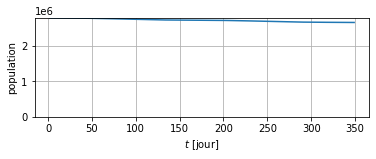

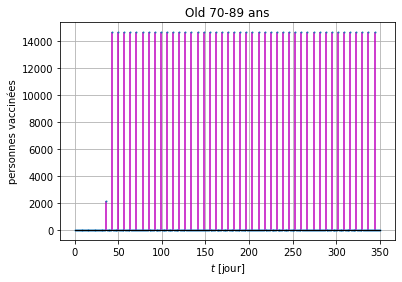

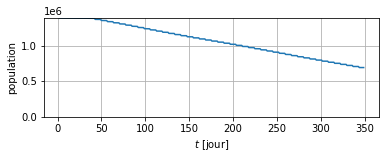

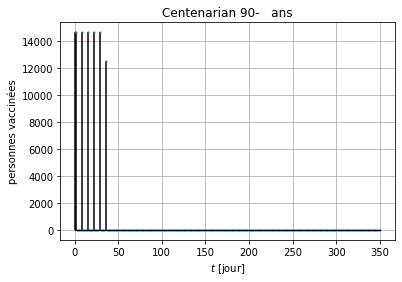

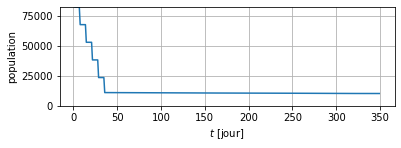

In [117]:
"""
plt.title(titres[i])
plt.plot(days[1:-1], susceptible[i])
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("population", fontsize=10)
plt.ylim((0, max(susceptible[i])))
plt.grid()
plt.show()
titres = [f"{population[i]}" for i in range(m)]
color = ['b','r','g','m','k']
plt.figure(figsize=(10, 10))
plt.title("Vaccination par classe d'âge")
signals = [[sum(y[t][m - 1 - i].x for i in range(l)) for t in days-1] for l in range(m)] 

for j in range(len(signals)):
    markerline, stemlines, baseline = plt.stem(days, signals[len(signals) - 1 - j], '-'+color[j], label=titres[j])
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    markerline.set_color(color[j])
    
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("personnes vaccinées", fontsize=10)
plt.grid()
plt.legend()
plt.show()
"""
# Titres
titres = [f"{population[i]}" for i in range(m)]
color = ['b','r','g','m','k']

plt.figure("Question 1.1")
for i in range(5):
        plt.subplot(1, 1, 1)
        plt.title(titres[i])
        markerline, stemlines, baseline = plt.stem(days, vaccination[i],'-'+color[i])       
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("personnes vaccinées", fontsize=10)

        baseline.set_color('k')
        baseline.set_linewidth(1)
        markerline.set_markersize(1)
        plt.grid()
        plt.show()
        
        plt.subplot(2, 1, 2)
        plt.plot(days[1:-1], susceptible[i])
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("population", fontsize=10)
        plt.ylim((0, max(susceptible[i])))
        plt.grid()
        plt.show()

### Question 1.2

On considère à présent le cas de $n$ provinces. Dans le cas de la Belgique, on aura $n=10$.
On autorise également le stockage des vaccins dans les centres.

Par rapport au modèle précédent, on introduit 
* $z_j^t \equiv$ le nombre de vaccins stockés au temps $t$ dans le centre de la province $j$, variable. Ces vaccins ne sont donc pas administrés au jour $t$.
* $(c_s)_j \equiv$ le coût associé au stockage d'un vaccin dans le centre $j$, connu.

Outre les contraintes identifiées plus haut, on ajoute le fait que tous les vaccins qui sont arrivés la veille ou qui étaient en stock la veille peuvent soit être administrés le lendemain, soit être mis en stock le lendemain.

Finalement, puisqu'on suppose que chaque province $j$ subit l'épidémie de manière indépendante, les contraintes sont propres à chacune d'entres elles, excepté les contraintes de coût total et de vaccins disponibles au hangar central.

De manière similaire à la question 1.1, on prend la convention:
* $x^0 = 0 = x^T$, car aucun vaccin n'a été livré la veille du début de la campagne ou ne doit être livré le dernier jour.
* $z^0 = 0 = z^T$, car aucun vaccin n'est disponible en stock la veille du début de la campagne ou ne doit être mis en stock le dernier jour.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, z, n_s}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t (n_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left(c_{tr}\ x_j^t + c_v \sum_{i=1}^{m} y_{ij}^t + c_s z_j^t\right) &\leq& c_{tot} \\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \\ 
x_j^t &\leq& (b_l)_j^t \\
\sum_{i=1}^{m} y_{ij}^t &\leq&\ (b_v)_j^t \\
\sum_{k=1}^t y_{ij}^k &\leq& \mu_{ij}\ (n_s)_{ij}^0 \\
x_j^{t-1} + z_j^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \\
(n_s)_{ij}^t - (1-\lambda_{ij}^{t-1})\ (n_s)_{ij}^{t-1} + y_{ij}^{t-1} &=&  0\\
x,\ y,\ z,\ n_s &\geq& 0
\end{eqnarray*}$$

In [118]:
# Données du problème
_lambda = pd.read_csv("Données-v1.1/Fraction_malade_province.csv")
_lambda = _lambda.set_index('Tranche')

population_Province = pd.read_csv("Données-v1.1/Population_province.csv")

# Données du problème
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
n = 10                # Nombre de provinces
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_s   = 0             # Coût de stockage
c_tot = 100e6         # budget total autorisé
b_l   = float("inf")  # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

print(type(population_Province))
_lambda

# A supprimer prochainement :
# arrays = [population_Province["Province"], population_Province["Tranche"]]
# index = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=["Province","Tranche"])
# population_Province = pd.Series(population_Province["Population"].to_numpy(),index)

<class 'pandas.core.frame.DataFrame'>


,Province de Flandre orientale,Province de Flandre occidentale,Province du Brabant flamand,Province d’Anvers,Province du Hainaut,Province de Liège,Province du Limbourg,Province du Luxembourg,Province du Brabant wallon,Province de Namur,Bruxelles
Tranche,,,,,,,,,,,
young,0.000298,0.000219,0.000223,0.000184,0.000218,0.000122,0.000147,0.000268,0.000286,0.000249,0.000185
adult,0.000301,0.000261,0.000219,0.000241,0.000283,0.000146,0.000160,0.000288,0.000306,0.000274,0.000313
senior,0.000204,0.000176,0.000130,0.000159,0.000220,0.000122,0.000117,0.000194,0.000229,0.000230,0.000291
old,0.000209,0.000164,0.000089,0.000122,0.000230,0.000131,0.000094,0.000127,0.000203,0.000194,0.000220
centanarian,0.000329,0.000180,0.000207,0.000079,0.000132,0.000227,0.000019,0.000400,0.000612,0.000160,0.000311


In [119]:
# Fonctions utiles à l'algorithme

def init_variables(model, m, n, t):
    """
    Initialise les variables x,y,z au format: x[t][j], y[t][j][i], z[t][j], n_s[t][j][i].
    
    @args: 
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
    
    @returns:
        x: List[List[Var]]: variables de livraison
        y: List[List[List[Var]]]: variables d'administration des vaccins
        z: List[List[Var]]: variables de stockage
        n_s: List[List[List[Var]]]: nombre de susceptibles
    """  
    x = model.add_var_tensor((t, n), 'x')
    y = model.add_var_tensor((t, n, m), 'y')
    z = model.add_var_tensor((t, n), 'z')
    n_s = model.add_var_tensor((t, n, m), 'n_s')
    
    return x,y,z,n_s

def init_population(population_Province, m, n):
    """
    Initialise la population de susceptibles au format: n_s_init[j][i].
    
    @args: 
        y: List[List[List[Var]]]: variables d'administration des vaccins
        _lambda: pandas DataFrame: données sur la fraction des malades
        population_Province: pandas DataFrame: données sur la population initiale dans chaque province.
    
    @returns: 
        n_s: List[List[int]]: population de susceptibles dans chaque province pour tout t.
        province: List[String]: noms des provinces.
        tranche: List[String]: noms des tranches
    """
    province = _lambda.columns.to_numpy()
    tranche =  _lambda.index.to_numpy()
    pop = population_Province["Population"].to_numpy()        
    n_s_init = [[pop[i+m*j] for i in range(m)] for j in range(n)]    
    return n_s_init, province, tranche    

In [120]:
# Résolution du problème
model_I2 = Model('multi-centre', sense=MINIMIZE, solver_name=CBC)
model_I2.clear() # On clear pour être sûr que le modèle soit réinitialisé comme il faut

# Initialisation des variables
x,y,z,n_s = init_variables(model_I2, m, n, len(days))
n_s_init, province, tranche = init_population(population_Province, m, n)

# Objectif
model_I2.objective = minimize(xsum(_epsilon[i,t] * _lambda[province[j]][tranche[i]] * n_s[t-1][j][i] 
                                for i in range(m) for j in range(n) for t in days[1:-1]))

# Contrainte sur le coût total
model_I2 +=  xsum(c_tr * x[t][j] for j in range(n) for t in days-1) \
         + xsum(c_v * y[t][j][i] for i in range(m) for j in range(n) for t in days-1) \
         + xsum(c_s * z[t][j] for j in range(n) for t in days-1) <= c_tot

# Contrainte sur la quantité de vaccins livrables au temps t
for t in days-1:   
    model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t]
    
# Contrainte sur le nombre de vaccins administrables au temps t    
for t in days-1:       
    for j in range(n):                     
        model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v # b_v est commun a toutes les provinces
        
# Contrainte sur le nombre de vaccins livrables au temps t    
for t in days-1:       
    for j in range(n):                     
        model_I2 += xsum(x[t][j] for i in range(m)) <= b_l # b_l est commun a toutes les provinces
        
# Contrainte sur le nombre de personnes vaccinables au temps t        
for t in days-1:       
    for j in range(n):        
        for i in range(m):
            model_I2 += xsum(y[k][j][i] for k in range(t)) - mu[i] * n_s_init[j][i]  <= 0

# Contraintes physiques
for t in days-1:
    yy = y[t-1] if t >= 1 else np.zeros_like(y[0])
    for j in range(n):    
        # Population de susceptibles hier
        yn_s = n_s[t-1] if t >= 1 else n_s_init
        for i in range(m):
            # Contrainte sur la population
            model_I2 += n_s[t][j][i] - (1 - _lambda[province[j]][tranche[i]]) * yn_s[j][i] + yy[j][i] == 0
        if t >= 1: 
            # Contrainte physique sur la quantité de vaccins disponibles et stockables au temps t
            model_I2 += x[t-1][j] + z[t-1][j] - xsum(y[t][j][i] for i in range(m)) - z[t][j] >= 0

# On ne peut stocker ou administrer aucun vaccin le premier jour.
for j in range(n):   
    model_I2 += z[0][j] == 0 # /!\ le dual a une solution énorme à cause de l'égalité... (1e+308)
    for i in range(m):
        model_I2 += y[0][j][i] == 0
        
model_I2.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [121]:
print(f"f(x,y,z) = {model_I2.objective_value}")

# Sauvegarde des données du solveur
# model_I2.write("Q1_2.lp")
# model_I2.write("Q1_2.sol")

f(x,y,z) = 19065.55100419782


In [122]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [[x[t][j].x for t in days-1] for j in range(n)]
vaccination = [sum(y[t][j][i].x for j in range(n) for i in range(m)) for t in days-1]
stockage = [[z[t][j].x for t in days-1] for j in range(n)]

population = [sum(n_s[t-1][j][i].x for j in range(n) for i in range(m)) for t in days[1:-1]]
pop_morte  = [sum(_epsilon[i,t] * _lambda[province[j]][tranche[i]] * n_s[t-1][j][i].x for j in range(n) for i in range(m)) for t in days[1:-1]]


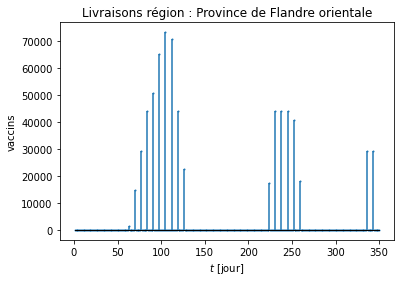

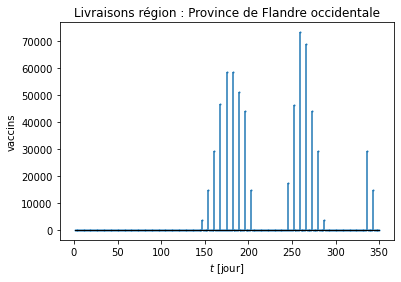

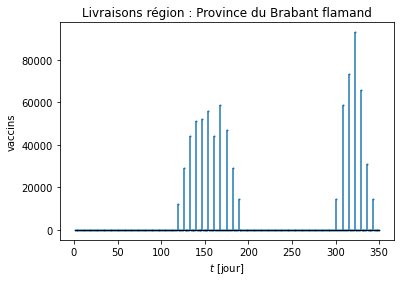

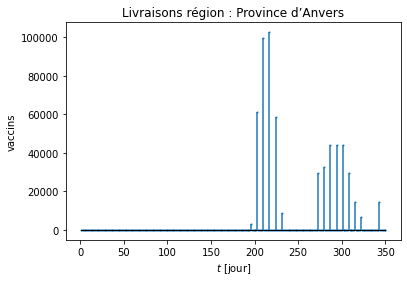

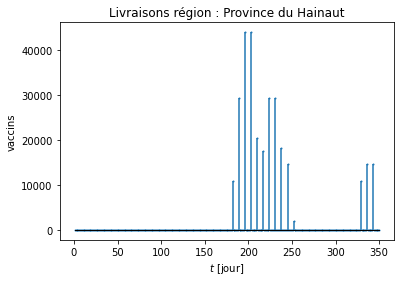

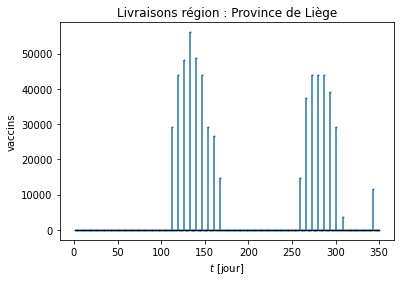

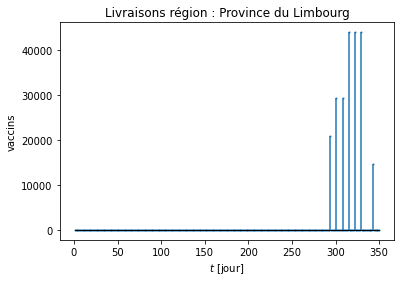

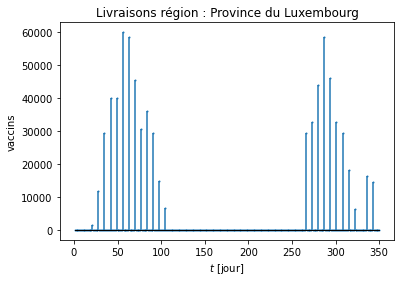

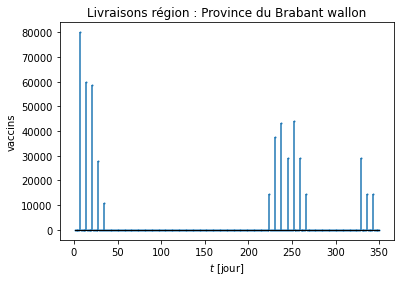

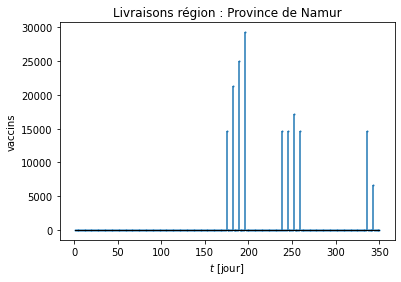

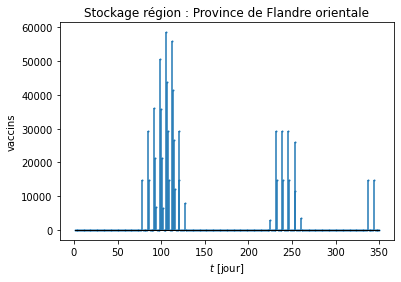

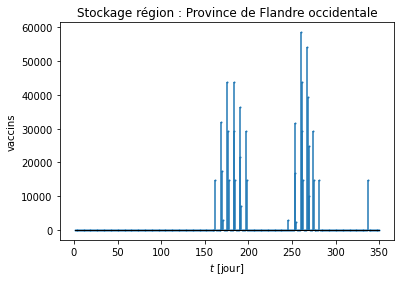

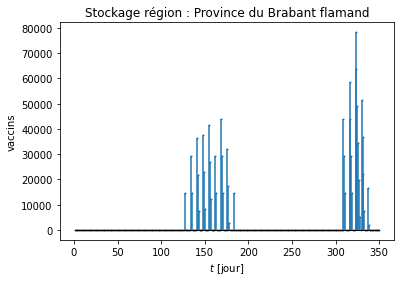

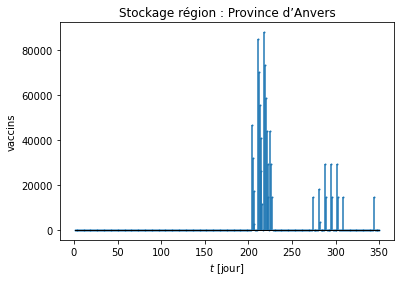

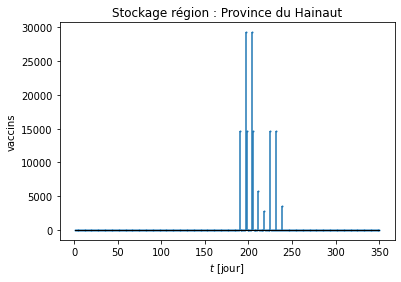

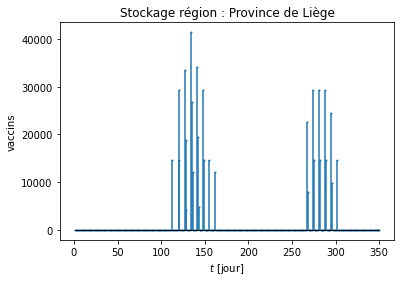

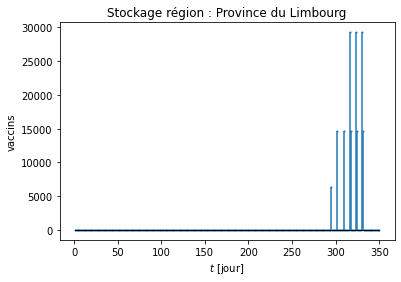

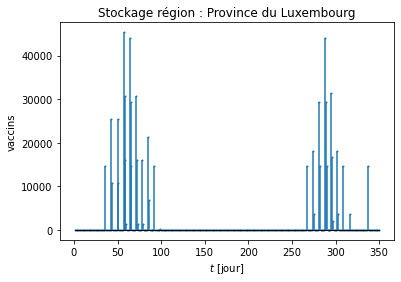

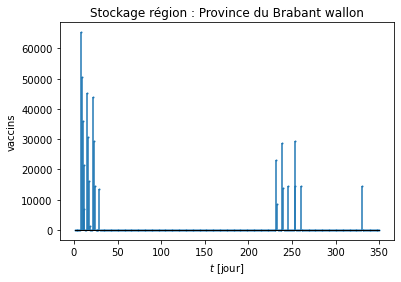

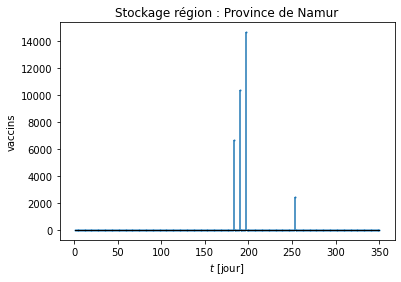

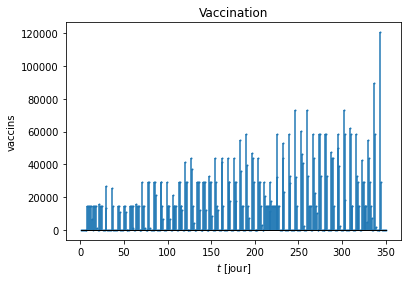

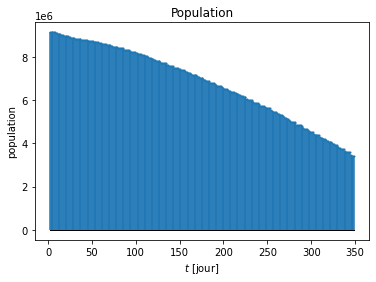

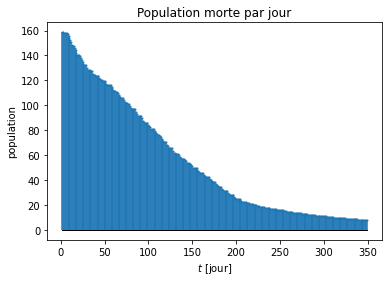

In [123]:
# Plot des livraisons
for j in range(n):
    plt.figure(j)
    plt.title(f"Livraisons région : {province[j]}")
    markerline, stemlines, baseline = plt.stem(days, livraisons[:][j])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()

# Plot du stockage
for j in range(n):
    plt.figure(j)
    plt.title(f"Stockage région : {province[j]}")
    markerline, stemlines, baseline = plt.stem(days, stockage[:][j])
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("vaccins", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()
    
# Plot des vaccinations
plt.figure()
plt.title(f"Vaccination")
markerline, stemlines, baseline = plt.stem(days, vaccination)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  

# Plot de la population
plt.figure()
plt.title(f"Population")
markerline, stemlines, baseline = plt.stem(days[1:-1], population)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("population", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  


# Plot de la population morte
plt.figure()
plt.title(f"Population morte par jour")
markerline, stemlines, baseline = plt.stem(days[1:-1], pop_morte)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("population", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  

### Question 1.3
Pour estimer l'impact de la variation d'une contrainte sur la fonction objectif, on considère la solution du problème dual que l'on note $y_*$. D'après le cours théorique, nous savons que pour une variation $\Delta b$ du vecteur des contraintes $b$, la valeur de la fonction objectif

$$z = y_*^T b\ ,$$
sera modifiée d'une valeur
$$\\ \Delta z = y_*^T \Delta b\ .$$

In [124]:
y_star = np.array([contrainte.pi for contrainte in model_I2.constrs])

- (a) Pour une variation $\Delta c_{tot}$ du budget total, $\Delta b = (\Delta c_{tot},\ 0,\ 0,\ \cdots,\ 0)$ puisqu'il s'agit de notre première contrainte.

In [125]:
beta = 1e-3 # modifier
delta_b = np.zeros_like(y_star)
delta_b[0] = beta * c_tot
delta_z = y_star @ delta_b
print(f"Delta z = {delta_z}")
y_star[np.absolute(y_star) < 1e-9] = 0
y_star

Delta z = 0.0


array([ 0.        , -0.01104264, -0.01095089, ...,  0.        ,
        0.        ,  0.        ])

- (b) On souhaite à présent déterminer la modification sur la quantité de vaccins disponibles nécessaire pour diminuer de 1 le nombre de morts. On note par $\Delta b_c$ le vecteur des modifications sur les quantités disponibles, de même taille que $b_c$. On souhaite donc trouver $\Delta b$ tel que 

$$y_*^T \Delta b = a^T \Delta b_c = -1$$

où $\Delta b_c$ est le vecteur des composantes non nulles de $\Delta b$ et $a$ le vecteur des composantes de $y_*$ associées à $\Delta b_c$.

On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens de la norme $1$ (ou de la norme $\infty$). En outre, on impose que $\Delta b$ reste suffisamment faible par rapport à $b$. Le problème s'écrit 

$$\begin{eqnarray*}
& min_{\ t,\Delta b_c} &\ t &\\
a^T \Delta b_c + 1 & \ge & -t \\
a^T \Delta b_c + 1 & \leq & t \\
\Delta (b_c)_k & \leq & \beta\ b_c^k \qquad \forall k, \quad \beta < 1
\end{eqnarray*}$$



$$%OLD VERSION$$
$$%On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens des moindres carrés de la manière suivante:
%A^T A x = A^T u
%avec
%A = \begin{pmatrix}
%  &   &   &   & y_*^T &        &   &   \\
%1 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0 & 0 \\
%\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 1 \\
%\end{pmatrix}; \qquad u =  \begin{pmatrix} -1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}; \qquad x = \Delta b$$


In [126]:
def approx_delta(a, b, beta):
    """ 
    minimisation de la valeur absolue des résidus
        min |a . x + 1| sc x <= beta * b
    """
    model = Model('residus', sense=MINIMIZE)
    delta_b = np.array([model.add_var() for _ in range(len(a))])
    t = model.add_var()
    model.objective = minimize(t)

    model += xsum(a * delta_b) + 1 + t >= 0
    model += xsum(a * delta_b) + 1 - t <= 0

    for i in range(len(delta_b)):
        model += delta_b[i] <= beta * b[i]

    model.optimize()
    return model, delta_b

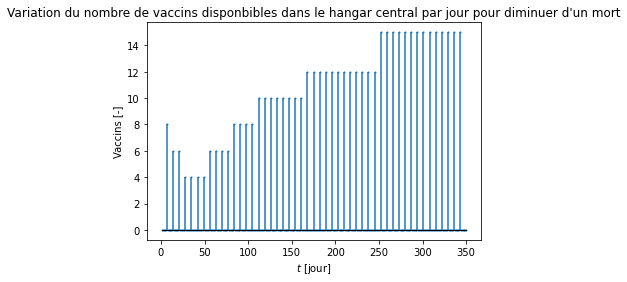

In [127]:
# Résolution du problème
a = y_star[1:len(b_c)+1]
q13_b, delta_b_c = approx_delta(a, b_c, 1e-4)

delta = np.array([delta_b_c[i].x for i in range(len(delta_b_c))])

plt.figure()
plt.title("Variation du nombre de vaccins disponbibles dans le hangar central par jour pour diminuer d'un mort")
markerline, stemlines, baseline = plt.stem(days, delta_b_c)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("Vaccins [-]", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()  

- (c) On estime l'impact d'une modification sur les contraintes de capacités et de coût de manière similaire au point (b). On remplace donc dans l'énoncé précédent $\Delta b_c$ successivement par $\Delta b_v$ le vecteur des modifications sur les vaccins administrables et $\Delta b_l$ le vecteur des modifications sur les vaccins livrables.

In [128]:
b1 = np.ones(len(days)*n)*b_l
a1 = y_star[len(b_c)+1:len(b_c)+len(b1)+1]

q13_c1, delta_b_l = approx_delta(a1, b1, 1e-4)
delta = np.array([delta_b_l[i].x for i in range(len(delta_b_l))])
print(f"Delta b_l = \n{delta}")
print(f"Delta z = {a1 @ delta}")

Delta b_l = 
[0. 0. 0. ... 0. 0. 0.]
Delta z = -1.0


In [131]:
# modification du nombre de vaccins administrables par jour dans chaque centre.

b2 = np.ones(len(days)*n)*b_v
a2 = y_star[len(b_c)+len(b1)+1:len(b_c)+len(b1)+1+len(b2)]

q13_c2, delta_b_v = approx_delta(a2, b2, 1e-2)
delta = np.array([delta_b_v[i].x for i in range(len(delta_b_v))])
print(f"Delta b_v = {delta}")
print(f"Delta z = {a2 @ delta}")


#A FAIRE -> METTRE SOUS FORME DE MATRICE
"""
plt.figure()
plt.title("Variation du nombre de vaccins administrables par jour pour diminuer d'un mort")
markerline, stemlines, baseline = plt.stem(days, delta_b_v)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("Vaccins [-]", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show() 
"""

Delta b_v = [0. 0. 0. ... 0. 0. 0.]
Delta z = 0.0


'\nplt.figure()\nplt.title("Variation du nombre de vaccins administrables par jour pour diminuer d\'un mort")\nmarkerline, stemlines, baseline = plt.stem(days, delta_b_v)\nplt.xlabel("$t$ [jour]", fontsize=10)\nplt.ylabel("Vaccins [-]", fontsize=10)\nbaseline.set_color(\'k\')\nbaseline.set_linewidth(1)\nmarkerline.set_markersize(1)\nplt.show() \n'

In [ ]:
# len(c_tot) + len(b_c) + len(b_l) + len(b_v) + len(mu)
#b3 = [mu[i] * n_s_init[j][i] for j in range(n) for i in range(m)] # Vérifier l'ordre
#a3 = y_star[count:count+len(b3)]
#q13_c2, delta_b = approx_delta(a3, b3, 1e-3)
#delta = np.array([delta_b[i].x for i in range(len(delta_b))])
#print(f"Delta mu * n_s_init = \n{delta}")
#print(f"Delta z = {a3 @ delta}")

In [ ]:
#with open("y_star.txt", 'w') as f:
#    for i in y_star:
#        f.write(str(i) + "\n")
#
#sol = np.linalg.solve(np.outer(a,a), -a)


#s = ''
#for i in range(len(a)):
#    s += f" x_{i}"

#delta_b = sm.symbols(s)
#A = sm.Matrix(a).T
#X = sm.Matrix(delta_b)
#system = A.T * A * X + A.T * sm.Matrix([1])
"""
p = len(y_star)
o = p - len(b_c)
A = dok_matrix((o,p), dtype=np.float32)
A[1,0] = 1
for i in range(2, o-2):
    A[i,i-1 + len(b_c)] = 1
u = np.zeros((o,1))
u[0] = -1

soluce = spsolve(A, u)
print(soluce)
"""